# DataJoint U24 - Workflow Array Electrophysiology

## Setup

First, let's change directories to find the `dj_local_conf` file.

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='workflow-array-ephys', ("Please move to the "
                                                               + "workflow directory")
# We'll be working with long tables, so we'll make visualization easier with a limit
import datajoint as dj; dj.config['display.limit']=10

Next, we populate the python namespace with the required schemas

In [2]:
from workflow_array_ephys.pipeline import session, ephys, trial, event
from workflow_array_ephys import analysis

Connecting cbroz@dss-db.datajoint.io:3306


## Trial and Event schemas

Tables in the `trial` and `event` schemas specify the structure of your experiment, including block, trial and event timing. 
- Session has a 1-to-1 mapping with a behavior recording
- A block is a continuous phase of an experiment that contains repeated instances of a condition, or trials. 
- Events may occur within or outside of conditions, either instantaneous or continuous.

The diagram below shows (a) the levels of hierarchy and (b) how the bounds may not completely overlap. A block may not fully capture trials and events may occur outside both blocks/trials.

```
|----------------------------------------------------------------------------|
|-------------------------------- Session ---------------------------------|__
|-------------------------- BehaviorRecording -----------------------------|__
|----- Block 1 -----|______|----- Block 2 -----|______|----- Block 3 -----|___
| trial 1 || trial 2 |____| trial 3 || trial 4 |____| trial 5 |____| trial 6 |
|_|e1|_|e2||e3|_|e4|__|e5|__|e6||e7||e8||e9||e10||e11|____|e12||e13|_________|
|----------------------------------------------------------------------------|
```

Let's load some example data. The `ingest.py` script has a series of loaders to help.

In [3]:
from workflow_array_ephys.ingest import ingest_subjects, ingest_sessions,\
                                        ingest_events, ingest_alignment

In [4]:
ingest_subjects(); ingest_sessions(); ingest_events()


---- Inserting 0 entry(s) into subject ----

---- Insert 0 entry(s) into probe.Probe ----

---- Insert 0 entry(s) into ephys.ProbeInsertion ----

---- Insert 0 entry(s) into session.Session ----

---- Successfully completed workflow_array_ephys/ingest.py ----

---- Inserting 1 entry(s) into behavior_recording ----

---- Inserting 2 entry(s) into behavior_recording__file ----

---- Inserting 4 entry(s) into _block ----

---- Inserting 4 entry(s) into _block__attribute ----

---- Inserting 0 entry(s) into #trial_type ----

---- Inserting 100 entry(s) into _trial ----

---- Inserting 100 entry(s) into _trial__attribute ----

---- Inserting 100 entry(s) into _block_trial ----

---- Inserting 0 entry(s) into #event_type ----

---- Inserting 153 entry(s) into _event ----

---- Inserting 153 entry(s) into _trial_event ----


We have 100 total trials, either 'stim' or 'ctrl', with start and stop time

In [5]:
trial.Trial()

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject3,2021-10-25 13:06:40,1,stim,0.285,20.285
subject3,2021-10-25 13:06:40,2,ctrl,23.927,43.927
subject3,2021-10-25 13:06:40,3,stim,47.622,67.622
subject3,2021-10-25 13:06:40,4,ctrl,71.443,91.443
subject3,2021-10-25 13:06:40,5,ctrl,95.385,115.385
subject3,2021-10-25 13:06:40,6,ctrl,119.331,139.331
subject3,2021-10-25 13:06:40,7,ctrl,143.254,163.254
subject3,2021-10-25 13:06:40,8,stim,166.86,186.86
subject3,2021-10-25 13:06:40,9,ctrl,190.465,210.465
subject3,2021-10-25 13:06:40,10,ctrl,214.395,234.395


Each trial is paired with one or more events that take place during the trial window.

In [6]:
trial.TrialEvent() & 'trial_id<5'

subject,session_datetime,trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start
subject3,2021-10-25 13:06:40,1,center,2.794
subject3,2021-10-25 13:06:40,1,center,13.252
subject3,2021-10-25 13:06:40,3,center,59.234
subject3,2021-10-25 13:06:40,4,center,76.33
subject3,2021-10-25 13:06:40,4,center,82.185
subject3,2021-10-25 13:06:40,4,center,89.928
subject3,2021-10-25 13:06:40,1,left,16.014
subject3,2021-10-25 13:06:40,3,left,52.128
subject3,2021-10-25 13:06:40,3,left,65.688
subject6,2021-01-15 11:16:38,1,center,10.58


Finally, the `AlignmentEvent` describes the event of interest and the window we'd like to see around it.

In [7]:
ingest_alignment()


---- Inserting 0 entry(s) into alignment_event ----


In [8]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type
center_button,,center,0.0,center,-5.0,center,5.0
left_button,,left,0.0,left,-5.0,left,5.0
right_button,,right,0.0,right,-5.0,right,5.0


## Event-aligned spike times

First, we'll check that the data is still properly inserted from the previous notebooks.

In [9]:
ephys.CuratedClustering()

subject,session_datetime,insertion_number,paramset_idx
subject6,2021-01-15 11:16:38,0,0


For this example, we'll be looking at `subject6`.

In [7]:
clustering_key = (ephys.CuratedClustering 
                  & {'subject': 'subject6', 'session_datetime': '2021-01-15 11:16:38',
                     'insertion_number': 0}
                 ).fetch1('KEY')

In [11]:
trial.Trial & clustering_key

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject6,2021-01-15 11:16:38,1,stim,0.123,17.123
subject6,2021-01-15 11:16:38,2,ctrl,17.54,34.54
subject6,2021-01-15 11:16:38,3,ctrl,34.81,51.81
subject6,2021-01-15 11:16:38,4,ctrl,52.202,69.202
subject6,2021-01-15 11:16:38,5,stim,69.611,86.611
subject6,2021-01-15 11:16:38,6,stim,87.03,104.03
subject6,2021-01-15 11:16:38,7,ctrl,104.165,121.165
subject6,2021-01-15 11:16:38,8,ctrl,121.502,138.502
subject6,2021-01-15 11:16:38,9,ctrl,138.612,155.612
subject6,2021-01-15 11:16:38,10,stim,155.741,172.741


And we can narrow our focus on `ctrl` trials.

In [10]:
ctrl_trials = trial.Trial & clustering_key & 'trial_type = "ctrl"'

The `analysis` schema provides example tables to perform event-aligned spike-times analysis.

In [ ]:
(dj.Diagram(analysis) + dj.Diagram(event.AlignmentEvent) + dj.Diagram(trial.Trial) + 
    dj.Diagram(ephys.CuratedClustering))

Let's start by creating an analysis configuration - i.e. inserting into ***SpikesAlignmentCondition*** for the `center` event, called `center_button` in the `AlignmentEvent` table.

In [11]:
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"'
                ).fetch1('KEY')
alignment_condition = {**clustering_key, **alignment_key, 
                       'trial_condition': 'ctrl_center_button',
                       'bin_size':.2}
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
alignment_condition.pop('bin_size')
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * ctrl_trials & alignment_condition).proj(),
    skip_duplicates=True)

With the steps above, we have created a new spike alignment condition for analysis, named `ctrl_center_button`, which retains all spiking information related to control trials during which the center button was pressed.

In [19]:
analysis.SpikesAlignmentCondition.Trial()

subject,session_datetime,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,2
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,3
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,4
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,7
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,8
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,9
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,13
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,14
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,15
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,16


Now, let's create another set for the stimulus condition.

In [8]:
stim_trials = trial.Trial & clustering_key & 'trial_type = "stim"'
alignment_condition = {**clustering_key, **alignment_key, 
                       'trial_condition': 'stim_center_button',
                       'bin_size':.2}
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
alignment_condition.pop('bin_size')
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * stim_trials & alignment_condition).proj(),
    skip_duplicates=True)

We can compare conditions in the `SpikesAlignmentCondition` table.

In [21]:
analysis.SpikesAlignmentCondition()

subject,session_datetime,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,condition_description,bin_size bin-size (in second) used to compute the PSTH
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,,0.04
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,,0.04


In [23]:
analysis.SpikesAlignmentCondition.Trial & 'trial_condition = "stim_center_button"'

subject,session_datetime,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,1
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,5
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,6
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,10
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,11
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,12
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,17
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,18
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,19
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,21


## Computation

Now let's run the computation on these.

In [11]:
analysis.SpikesAlignment.populate(display_progress=True)

SpikesAlignment: 100%|██████████| 1/1 [00:11<00:00, 11.26s/it]


## Visualize

We can visualize the results with the `plot` function with our keys.

In [3]:
clustering_key = (ephys.CuratedClustering 
                  & {'subject': 'subject6', 'session_datetime': '2021-01-15 11:16:38',
                     'insertion_number': 0}
                 ).fetch1('KEY')
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"'
                ).fetch1('KEY')

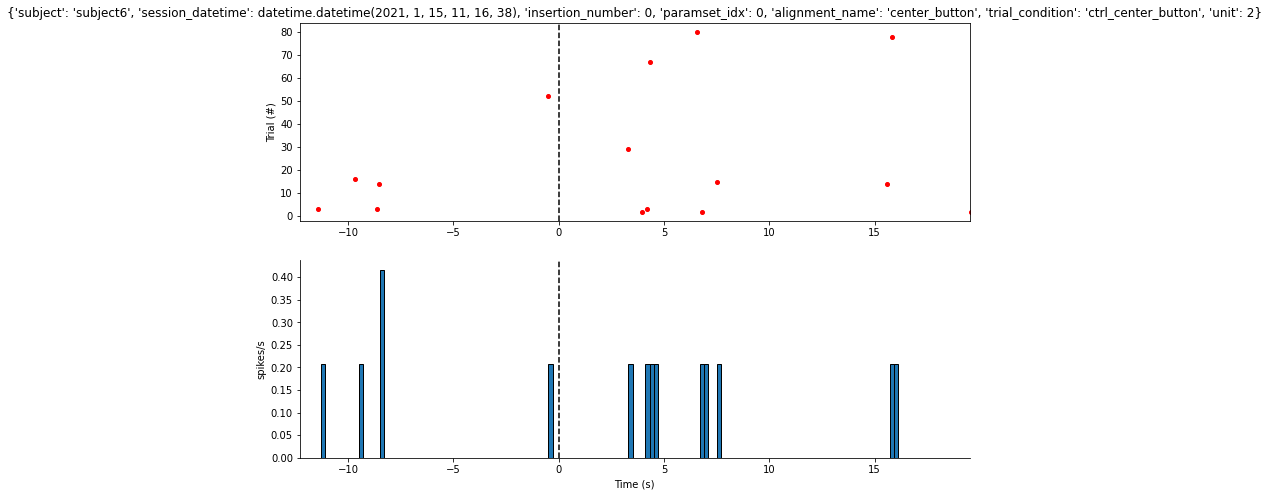

In [4]:
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'ctrl_center_button'}
analysis.SpikesAlignment().plot(alignment_condition, unit=2);

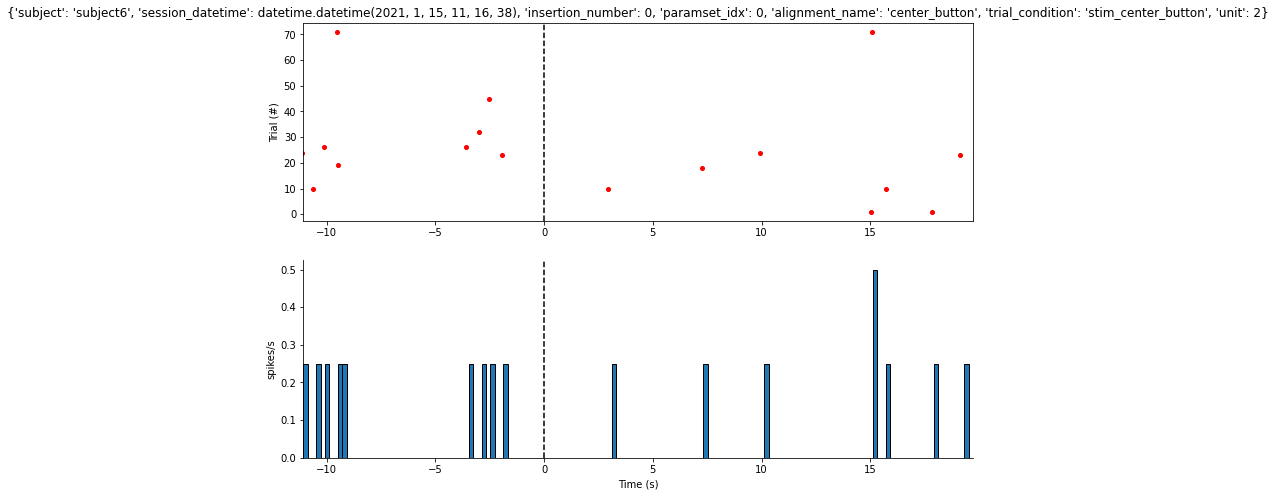

In [12]:
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'stim_center_button'}
analysis.SpikesAlignment().plot(alignment_condition, unit=2);